In [1]:
%run boilerplate.py

DEVICE = device(type='cpu')
os.getcwd()='/Users/shravan.shetty/Downloads/PGit/movie-lens-camile'


In [2]:
import pandas as pd
import json
from tqdm import tqdm_notebook, tqdm
from time import time, ctime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline


In [94]:
import numpy as np

In [3]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import  f_regression,  mutual_info_regression
from sklearn.preprocessing import TargetEncoder, PolynomialFeatures

In [58]:
from sklearn.preprocessing import StandardScaler

In [4]:
import seaborn as sns

In [5]:
movies = pd.read_csv(DIR_DATA.joinpath('movies.csv'))
ratings = pd.read_csv(DIR_DATA.joinpath('ratings.csv'))
tags = pd.read_csv(DIR_DATA.joinpath('tags.csv'))
links = pd.read_csv(DIR_DATA.joinpath('links.csv'))


## Understanding data

### Understanding movies data

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies.describe(include="all")

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


Total movies 9737, There are duplicate titles for movies, but that is understandable. Eg Emma was release twice by different directors

In [8]:
# Duplicate entries of same movies. Emma and War of world are two diff movies with same name, but others are duplicates
movies[movies.title.duplicated(keep = False)].sort_values('title')

,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


#### Adding genre feature

In [12]:

genre_cols = set()
for i, genres in movies.genres.str.split('|').apply(set).iteritems():
    for g in genres:
        if g not in genre_cols:
            movies[g] = 0
            genre_cols.add(g)
        movies.loc[i,g] = 1

In [14]:
movies.head()

,movieId,title,genres,Comedy,Animation,Adventure,Fantasy,Children,Romance,Drama,Crime,Thriller,Action,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# geners with poor variance and mostly 0
movies[genre_cols].var().loc[lambda x: x<0.01]
a = movies[genre_cols].var().loc[lambda x: x<0.01].index
movies.drop(a,1,inplace=True)
genre_cols = genre_cols - set(a)


Removing below genres as they have poor variance and occur quite less

In [15]:
set(a)

{'(no genres listed)', 'Film-Noir'}

### Tags 

In [19]:
tags.describe(include="all")

,userId,movieId,tag,timestamp
count,3683.000000,3683.000000,3683,3.683000e+03
unique,NaN,NaN,1589,NaN
top,NaN,NaN,In Netflix queue,NaN
freq,NaN,NaN,131,NaN
mean,431.149335,27252.013576,NaN,1.320032e+09
std,158.472553,43490.558803,NaN,1.721025e+08
min,2.000000,1.000000,NaN,1.137179e+09
25%,424.000000,1262.500000,NaN,1.137521e+09
50%,474.000000,4454.000000,NaN,1.269833e+09
75%,477.000000,39263.000000,NaN,1.498457e+09


In [86]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Links 

In [87]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [89]:
links.describe(include="all")

,movieId,imdbId,tmdbId
count,9742.000000,9.742000e+03,9734.000000
mean,42200.353623,6.771839e+05,55162.123793
std,52160.494854,1.107228e+06,93653.481487
min,1.000000,4.170000e+02,2.000000
25%,3248.250000,9.518075e+04,9665.500000
50%,7300.000000,1.672605e+05,16529.000000
75%,76232.000000,8.055685e+05,44205.750000
max,193609.000000,8.391976e+06,525662.000000


## TMDB data

In [18]:
res = []
issue_files = []
tot_files = list(DIR_DATA_TMDB.glob('*.json'))

for file in tqdm(tot_files):
    try:
        basefile = int(float(file.stem))
        res.append(pd.read_json(file, orient='index').rename(columns= {0:basefile}).T)
    except Exception as e:
        issue_files.append((str(file), str(e)))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9620/9620 [00:25<00:00, 370.43it/s]


In [20]:
tmdb = pd.concat(res)
tmdb = tmdb.infer_objects()

In [21]:
tmdb = tmdb.rename(columns = {'id': 'tmdbId'})

In [22]:
tmdb.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
overview,9620,9607,,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,9620.0,NaN,NaN,NaN,17.822945,17.637441,0.6,8.769,13.5045,21.084,679.514
original_title,9620,9348,The Three Musketeers,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runtime,9620.0,NaN,NaN,NaN,104.34158,24.447468,2.0,92.0,102.0,115.0,583.0
release_date,9620,6214,2006-09-09,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vote_average,9620.0,NaN,NaN,NaN,6.510825,0.866085,0.0,6.0,6.564,7.11425,8.917
vote_count,9620.0,NaN,NaN,NaN,1462.200416,2922.985697,0.0,127.75,409.5,1374.25,34704.0
status,9620,1,Released,9620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tagline,9620,8019,,1569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spoken_languages,9620,984,en,5960,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
tmdb.head()

,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,status,tagline,spoken_languages,cast,tmdbId
379,"Set in 1929, a political boss and his advisor have a parting of the ways when they both fall for ...",17.518,Miller's Crossing,115,1990-09-21,7.455,1496,Released,"Up is down, black is white, and nothing is what it seems.",en|ga|it|yi,Gabriel Byrne|Albert Finney|Jon Polito|Marcia Gay Harden|John Turturro,379
9286,"A student's premonition of a deadly rollercoaster ride saves her life and a lucky few, but not fr...",40.900,Final Destination 3,93,2006-02-09,6.081,3549,Released,This ride will be the death of you.,en,Mary Elizabeth Winstead|Ryan Merriman|Kris Lemche|Alexz Johnson|Sam Easton,9286
13398,"On Christmas Eve, three homeless people living on the streets of Tokyo discover a newborn baby am...",21.095,東京ゴッドファーザーズ,93,2003-12-29,7.895,1076,Released,Meet the ultimate dysfunctional family.,en|ja|es,Aya Okamoto|Yoshiaki Umegaki|Tohru Emori|Satomi Korogi|Mamiko Noto,13398
18887,A wily old codger matches wits with the King of the Leprechauns and helps play matchmaker for his...,12.456,Darby O'Gill and the Little People,93,1959-06-24,6.700,130,Released,A touch O'Blarney... a heap O'Magic and A LOAD O'LAUGHTER!,ga|en,Albert Sharpe|Janet Munro|Sean Connery|Jimmy O'Dea|Kieron Moore,18887
25750,A bright young medical student must solve the frightening mystery that plagues the children of a ...,8.874,Children of the Corn IV: The Gathering,85,1996-10-08,4.463,134,Released,In a sleepy midwestern town... A horrifying evil is about to rise again!,en,Naomi Watts|Jamie Renée Smith|Karen Black|Mark Salling|Brent Jennings,25750


### Adding column in TMDB data

#### Create Primary language

Updating Primary language as the first in spoken language

In [24]:
# First spoken language as Using Primary language
tmdb['primary_lang'] = tmdb.spoken_languages.str.split('|', expand=True)[0]

#### Release date columns

In [25]:
tmdb['release_date'] = pd.to_datetime(tmdb.release_date)
tmdb['release_date_yr'] = tmdb.release_date.dt.year
tmdb['release_date_month'] = tmdb.release_date.dt.month
tmdb['release_date_dow'] = tmdb.release_date.dt.day_of_week

#### Cast column

Splitting top 3 cast members

In [26]:
tmdb = pd.concat([tmdb, tmdb.cast.str.split('|', expand=True).add_prefix('cast_').iloc[:, :3]], axis=1)

## Merging data

### Merge movie with TMDB and related movie info

In [27]:
movies_all = movies.merge(links).merge(tmdb, how = 'left', indicator=True)
movies_all._merge.value_counts()
movies_all[movies_all._merge!='both']

,movieId,title,genres,Comedy,Animation,Adventure,Fantasy,Children,Romance,Drama,Crime,Thriller,Action,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,imdbId,tmdbId,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,status,tagline,spoken_languages,cast,primary_lang,release_date_yr,release_date_month,release_date_dow,cast_0,cast_1,cast_2,_merge
624,791,"Last Klezmer: Leopold Kozlowski, His Life and Music, The (1994)",Documentary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,113610,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
843,1107,Loser (1991),Comedy,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,102336,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,81454,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3027,4051,Horrors of Spider Island (Ein Toter Hing im Netz) (1960),Horror|Sci-Fi,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,56600,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3127,4207,Navy Seals (1990),Action|Adventure|War,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,100232,12773.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9603,176329,Ari Shaffir: Double Negative (2017),Comedy,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6254796,466986.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9634,179135,Blue Planet II (2017),Documentary,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6769208,463612.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9651,180263,The Shining (1997),Drama|Horror|Thriller,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,118460,106035.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9690,184257,Making a Murderer (2015),Crime|Documentary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,5189670,502892.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [28]:
movies_all.head()

,movieId,title,genres,Comedy,Animation,Adventure,Fantasy,Children,Romance,Drama,Crime,Thriller,Action,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,imdbId,tmdbId,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,status,tagline,spoken_languages,cast,primary_lang,release_date_yr,release_date_month,release_date_dow,cast_0,cast_1,cast_2,_merge
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,114709,862.0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear on...",100.954,Toy Story,81.0,1995-10-30,7.970,17277.0,Released,Hang on for the comedy that goes to infinity and beyond!,en,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn,en,1995.0,10.0,0.0,Tom Hanks,Tim Allen,Don Rickles,both
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,113497,8844.0,When siblings Judy and Peter discover an enchanted board game that opens the door to a magical wo...,13.981,Jumanji,104.0,1995-12-15,7.239,9891.0,Released,Roll the dice and unleash the excitement!,en|fr,Robin Williams|Kirsten Dunst|Bradley Pierce|Bonnie Hunt|Jonathan Hyde,en,1995.0,12.0,4.0,Robin Williams,Kirsten Dunst,Bradley Pierce,both
2,3,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,113228,15602.0,A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John ...,12.686,Grumpier Old Men,101.0,1995-12-22,6.494,350.0,Released,Still Yelling. Still Fighting. Still Ready for Love.,en,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia Loren|Daryl Hannah,en,1995.0,12.0,4.0,Walter Matthau,Jack Lemmon,Ann-Margret,both
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,114885,31357.0,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusiv...",11.945,Waiting to Exhale,127.0,1995-12-22,6.183,142.0,Released,Friends are the people who let you be yourself... and never let you forget it.,en,Whitney Houston|Angela Bassett|Loretta Devine|Lela Rochon|Gregory Hines,en,1995.0,12.0,4.0,Whitney Houston,Angela Bassett,Loretta Devine,both
4,5,Father of the Bride Part II (1995),Comedy,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113041,11862.0,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's...",19.558,Father of the Bride Part II,106.0,1995-12-08,6.239,665.0,Released,Just when his world is back to normal... he's in for the surprise of his life!,en,Steve Martin|Diane Keaton|Martin Short|Kimberly Williams-Paisley|George Newbern,en,1995.0,12.0,4.0,Steve Martin,Diane Keaton,Martin Short,both


### Movie and user rating merge

In [29]:
movies_ratings = movies_all.drop('_merge',1).merge(ratings)

In [30]:
# Null ratings
movies_ratings.rating.isnull().sum()

0

Fix null rating, based on median ratings for each genre and then taking mean across all genres

In [31]:
# Get median genre ratings
genre_ratings = { g:movies_ratings[movies_ratings[g]==1].rating.median() for g in genre_cols}
genre_ratings

{'Mystery': 4.0,
 'Action': 3.5,
 'Musical': 3.5,
 'Thriller': 3.5,
 'Sci-Fi': 3.5,
 'Adventure': 3.5,
 'Drama': 4.0,
 'Children': 3.5,
 'War': 4.0,
 'Comedy': 3.5,
 'Crime': 4.0,
 'Animation': 4.0,
 'Romance': 3.5,
 'Horror': 3.5,
 'IMAX': 4.0,
 'Documentary': 4.0,
 'Fantasy': 3.5,
 'Western': 4.0}

In [35]:
assert movies_ratings.rating.isnull().sum() == 0
assert movies_ratings.timestamp.isnull().sum() == 0

## Identifying factors

### Genre factor

Lets understand if genre is important feature for user rating.
To do that Lets understand if watching lot of same genre movies leads to higher user ratings for that particular genre.

#### At User Level: User Genre rating vs Total Genre movies watched

We will use - Mutual information analysis to test relationship between genre_rating and genre_movie_watched. 

eg If user watches lof to action movies, does that tend to higher action rating by user

In [ ]:
Step 1: Get 

In [37]:
user_genre = movies_ratings.groupby('userId')[list(genre_cols)].sum()

In [39]:
user_genre.head()

,Mystery,Action,Musical,Thriller,Sci-Fi,Adventure,Drama,Children,War,Comedy,Crime,Animation,Romance,Horror,IMAX,Documentary,Fantasy,Western
userId,,,,,,,,,,,,,,,,,,
1,18,90,22,55,40,85,68,42,22,83,45,29,26,17,0,0,47,7
2,2,11,0,10,4,3,17,0,1,7,10,0,1,1,4,3,0,1
3,1,14,1,7,15,11,16,5,5,9,2,4,5,8,0,0,4,0
4,23,25,16,38,12,29,120,10,7,104,27,6,58,4,1,2,19,10
5,1,9,5,9,2,8,25,9,3,15,12,6,11,1,3,0,7,2


In [44]:
def genre_mean(x):
    res = {}
    for g in genre_cols:
        mask = x[g]==1
        res[g]  = x.loc[mask, 'rating'].mean()
    return pd.Series(res)
user_genre_rating = movies_ratings.groupby('userId').apply(genre_mean)

In [45]:
user_genre_rating.head()

,Mystery,Action,Musical,Thriller,Sci-Fi,Adventure,Drama,Children,War,Comedy,Crime,Animation,Romance,Horror,IMAX,Documentary,Fantasy,Western
userId,,,,,,,,,,,,,,,,,,
1,4.166667,4.322222,4.681818,4.145455,4.225000,4.388235,4.529412,4.547619,4.500000,4.277108,4.355556,4.689655,4.307692,3.470588,NaN,NaN,4.297872,4.285714
2,4.000000,3.954545,NaN,3.700000,3.875000,4.166667,3.882353,NaN,4.500000,4.000000,3.800000,NaN,4.500000,3.000000,3.750000,4.333333,NaN,3.500000
3,5.000000,3.571429,0.500000,4.142857,4.200000,2.727273,0.750000,0.500000,0.500000,1.000000,0.500000,0.500000,0.500000,4.687500,NaN,NaN,3.375000,NaN
4,3.478261,3.320000,4.000000,3.552632,2.833333,3.655172,3.483333,3.800000,3.571429,3.509615,3.814815,4.000000,3.379310,4.250000,3.000000,4.000000,3.684211,3.800000
5,4.000000,3.111111,4.400000,3.555556,2.500000,3.250000,3.800000,4.111111,3.333333,3.466667,3.833333,4.333333,3.090909,3.000000,3.666667,NaN,4.142857,3.000000


Mutual information (MI)  between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [86]:
genre_mi = {}
for g in genre_cols:
    mask = user_genre_rating[g].notnull()
    scaled_user_genre_tot = StandardScaler().fit_transform(user_genre.loc[mask, [g]])
    scaled_user_genre_rating = StandardScaler().fit_transform(user_genre_rating.loc[mask, [g]])
    genre_mi[g] = mutual_info_regression(scaled_user_genre_tot,scaled_user_genre_rating )[0]

In [87]:
pd.Series(genre_mi).round(2).sort_values()

Drama          0.04
Action         0.10
Comedy         0.10
Thriller       0.16
Adventure      0.17
Crime          0.24
Romance        0.31
Sci-Fi         0.34
Documentary    0.35
Animation      0.36
Fantasy        0.37
Horror         0.41
IMAX           0.45
Western        0.46
Musical        0.48
Children       0.49
War            0.51
Mystery        0.58
dtype: float64

<b>From the above Genre, Users who watch Lot of Mystery, Musical, war, children tend to rate those genre higher

### Correlation matrix of continuous features

In [67]:
continuous_cols = movies_ratings.select_dtypes(include=[float, int]).columns
continuous_cols = continuous_cols.drop(['movieId', 'timestamp', 'userId', 'tmdbId', 'imdbId'])
continuous_cols

Index(['Comedy', 'Animation', 'Adventure', 'Fantasy', 'Children', 'Romance',
       'Drama', 'Crime', 'Thriller', 'Action', 'Horror', 'Mystery', 'Sci-Fi',
       'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'popularity',
       'runtime', 'vote_average', 'vote_count', 'release_date_yr',
       'release_date_month', 'release_date_dow', 'rating'],
      dtype='object')

<Axes: >

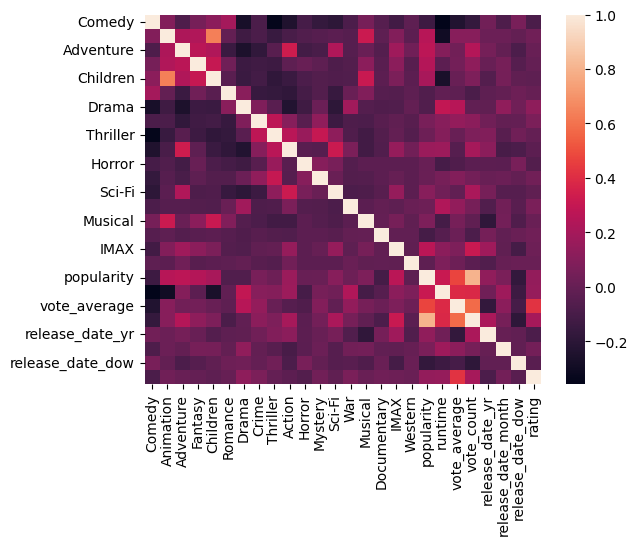

In [69]:
sns.heatmap(movies_ratings[continuous_cols].corr())

In [71]:
movies_ratings[continuous_cols].corr()['rating'].sort_values()

Comedy               -0.089101
release_date_yr      -0.084805
Horror               -0.065170
release_date_dow     -0.044393
Action               -0.033946
Children             -0.026941
Sci-Fi               -0.019968
Thriller             -0.004491
Fantasy              -0.003692
Romance               0.002224
Adventure             0.003797
Western               0.011038
Musical               0.012326
IMAX                  0.023192
Documentary           0.031432
Animation             0.033603
Mystery               0.036038
release_date_month    0.042916
War                   0.066202
Crime                 0.066935
Drama                 0.125131
popularity            0.142474
runtime               0.146576
vote_count            0.203402
vote_average          0.417687
rating                1.000000
Name: rating, dtype: float64

From the above  correlation tests following factors affect ratings:
* vote_average
* popularity
* vote_count
* runtime
* release_date
* Drama (Positive correlation with rating)
* Comedy (Negative correlation with rating)
* release_date_yr (Negative correlation with rating)
* Horror(Negative correlation with rating)

### TMDB feature analysis

In [84]:
tmdb_feat = ['popularity','runtime','vote_count','vote_average']

Since, we want to predict at user level, we want to check how these features affect with user level rating. 
For each user data, we compare TMDB features against user rating to check the significance based on mutual informaiton and correlaiton directions. 

In [ ]:
def compare_features(X, y, verbose = True):
    """
    Compare features in X against y  using mutual information and correlation. 
    
    """
    res = []
    mi = mutual_info_regression(X, y)
    if np.max(mi) > 0:
        mi /= np.max(mi)
    mutual_info = pd.Series(mi, X.columns).sort_values(ascending=False).map("{:.2f}".format).to_frame(name='Mutual_info')
    res.append(mutual_info)
    
    # f_test, _pv = f_regression(X, y)
    # f_test /= np.max(f_test)
    # pval = pd.DataFrame((f_test, _pv), index = ['f_test', 'pval'], columns= X.columns).sort_values('f_test', axis=1, ascending=False).applymap("{:.2f}".format).T
    # res.append(pval)
    
    corr = pd.concat([X,y],axis=1).corr()['rating'].drop('rating')
    corr = corr.sort_values(ascending=False).map("{:.2f}".format).to_frame(name='corr')
    res.append(corr)
    if verbose:
        for r in res:
            display(r.T)
    return pd.concat(res, axis=1)

    

def user_compare_features(user_df_features, user_df_target, cmp_item = 'Mutual_info'):
    """
    Take user dataframe of features and target and call the above compare_feature function to get MI and Correlation numbers.
    Also, tag the features that are significant and less significant. 
    """
    if user_df_features.shape[0] < 20:
        return pd.Series([])

    res_df = compare_features(user_df_features, user_df_target, verbose = False).astype(float)
    if cmp_item == 'Mutual_info':
        ser = pd.Series(
            np.select([res_df[cmp_item] < 0.1, res_df[cmp_item] >= 0.1], ['Not Significant', 'Significant']) 
        , index = res_df.index)
    if cmp_item == 'corr':
        ser =  pd.Series(
            np.select([res_df[cmp_item] > 0.33, res_df[cmp_item] < -0.33, ],[ 'corr > 0.33', 'corr < -0.33'],default='neutral')
        , index = res_df.index)
    return ser

In [145]:
corr_user_compare_res = []
for u in tqdm(movies_ratings.userId.unique()):

    x = movies_ratings[movies_ratings.userId == u]
    feat = x[tmdb_feat].dropna()
    target = x.loc[feat.index, ['rating']]
    r = user_compare_features(feat, target, cmp_item = 'corr')
    r.name = u
    corr_user_compare_res.append(r)


#  User level feature importance wrt rating. 
# We can see that  58% of the users find vote_average +ve correlated with rating
(pd.DataFrame(corr_user_compare_res)
 .apply(pd.Series.value_counts, normalize=True).T.mul(100)
 # .applymap("{:.1f}%".format).sort_values('Not Significant')
  .applymap("{:.1f}%".format).sort_values('neutral')
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:08<00:00, 75.23it/s]


,corr < -0.33,corr > 0.33,neutral
vote_average,0.8%,57.5%,41.6%
vote_count,0.7%,21.8%,77.5%
runtime,1.5%,12.6%,85.9%
popularity,0.8%,12.6%,86.6%


In [146]:
mi_user_compare_res = []
for u in tqdm(movies_ratings.userId.unique()):

    x = movies_ratings[movies_ratings.userId == u]
    feat = x[tmdb_feat].dropna()
    target = x.loc[feat.index, ['rating']]
    r = user_compare_features(feat, target, cmp_item = 'Mutual_info')
    r.name = u
    mi_user_compare_res.append(r)


#  User level feature importance wrt rating. 
# We can see that  58% of the users find vote_average +ve correlated with rating
(pd.DataFrame(mi_user_compare_res)
 .apply(pd.Series.value_counts, normalize=True).T.mul(100)
 .applymap("{:.1f}%".format).sort_values('Not Significant')

)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:08<00:00, 75.21it/s]


,Significant,Not Significant
vote_average,79.2%,20.8%
vote_count,64.4%,35.6%
popularity,59.7%,40.3%
runtime,58.7%,41.3%


From the Correlation  and Mutual informaiton, Vote_average is the most important predictor at user level followed by vote_count. 

### Cast

We want to understand if users who watch a lot of movies from a cast member tend to vote their movies higher

Using Cast_0 as that is prominent variable in cast. 

In [215]:
user_cast_ct = movies_ratings.groupby('userId')['cast_0'].value_counts()

user_cast_ct.head()

userId  cast_0         
1       Tom Hanks          6
        Harrison Ford      5
        Sean Connery       5
        Mel Gibson         4
        Michael Douglas    4
Name: cast_0, dtype: int64

In [217]:
cast_0_rating = movies_ratings.groupby(['cast_0']).rating.mean().reset_index(name='global_rating')
cast_0_rating.head()

,cast_0,global_rating
0,,3.777778
1,"""Weird Al"" Yankovic",3.444444
2,A. Michael Baldwin,2.000000
3,A.J. Cook,3.050000
4,Aamir Khan,4.500000


In [218]:
print("-----"*10)
print("Case when User rating for a cast member is more than global rating for same cast member")
print("-----"*10)
for NUM_MOVIE_CAST in range(2,10):
    print(f"When user watched atleast {NUM_MOVIE_CAST} movie")
    user_cast_rating = movies_ratings.groupby(['userId','cast_0']).rating.apply(lambda x: np.mean(x) if len(x) > NUM_MOVIE_CAST else np.nan)
    
    user_cast_rating = user_cast_rating.dropna().reset_index().merge(cast_0_rating)
    
    (user_cast_rating.rating >= user_cast_rating.global_rating).map({True: "User rating > Global", False: "User rating < Global"}).value_counts().sort_index().pipe(display)
    print("-----"*10)

--------------------------------------------------
Case when User rating for a cast member is more than global rating for same cast member
--------------------------------------------------
When user watched atleast 2 movie


User rating < Global    3664
User rating > Global    3811
dtype: int64

--------------------------------------------------
When user watched atleast 3 movie


User rating < Global    2086
User rating > Global    2008
dtype: int64

--------------------------------------------------
When user watched atleast 4 movie


User rating < Global    1332
User rating > Global    1211
dtype: int64

--------------------------------------------------
When user watched atleast 5 movie


User rating < Global    917
User rating > Global    770
dtype: int64

--------------------------------------------------
When user watched atleast 6 movie


User rating < Global    660
User rating > Global    510
dtype: int64

--------------------------------------------------
When user watched atleast 7 movie


User rating < Global    472
User rating > Global    336
dtype: int64

--------------------------------------------------
When user watched atleast 8 movie


User rating < Global    339
User rating > Global    231
dtype: int64

--------------------------------------------------
When user watched atleast 9 movie


User rating < Global    255
User rating > Global    164
dtype: int64

--------------------------------------------------


From the above analysis, Cast as a feature may not be strong predictor, as User level rating is not always better than Global rating

### Interaction variables importance

In [226]:
features = movies_ratings[continuous_cols].dropna()

In [242]:
target = movies_ratings.loc[features.index,'rating']

In [228]:
poly = PolynomialFeatures(include_bias=False, interaction_only=True)
intereaction_features = pd.DataFrame(poly.fit_transform(features.drop('rating',1)), columns=poly.get_feature_names_out())
features.shape, intereaction_features.shape, 

((100507, 26), (100507, 325))

In [243]:
interaction_res = compare_features(intereaction_features, target)

,vote_average release_date_yr,runtime vote_average,vote_average,popularity runtime,runtime vote_count,vote_average vote_count,popularity release_date_yr,popularity vote_count,popularity release_date_month,popularity,vote_average release_date_month,popularity vote_average,vote_count release_date_yr,vote_average release_date_dow,popularity release_date_dow,vote_count release_date_month,vote_count release_date_dow,vote_count,runtime release_date_yr,release_date_yr release_date_month,Drama vote_average,Comedy vote_average,Drama popularity,runtime release_date_month,Drama vote_count,Comedy popularity,Action vote_average,Comedy vote_count,release_date_yr release_date_dow,Action vote_count,Action popularity,Thriller vote_average,Thriller popularity,Thriller vote_count,runtime release_date_dow,release_date_yr,Adventure vote_average,Adventure popularity,Adventure vote_count,Sci-Fi vote_count,Crime vote_count,Crime vote_average,Sci-Fi vote_average,Sci-Fi popularity,Drama release_date_yr,Crime popularity,Romance popularity,Drama runtime,Romance vote_count,Romance vote_average,runtime,Fantasy vote_average,Horror vote_average,Comedy release_date_yr,Action release_date_yr,Children popularity,Fantasy popularity,Horror vote_count,Fantasy vote_count,Comedy runtime,Children vote_count,Action runtime,Adventure runtime,Drama release_date_month,Sci-Fi release_date_yr,Drama release_date_dow,Romance release_date_yr,Mystery vote_count,Adventure release_date_yr,Drama,Crime runtime,Crime release_date_yr,Thriller runtime,Thriller release_date_yr,release_date_month release_date_dow,Horror popularity,Children vote_average,War vote_count,Mystery popularity,Mystery runtime,War vote_average,Fantasy runtime,Animation popularity,War popularity,release_date_dow,Comedy release_date_month,Musical runtime,Animation vote_count,Children release_date_yr,Mystery vote_average,Comedy release_date_dow,Horror runtime,IMAX release_date_dow,Adventure Action,Horror release_date_yr,Sci-Fi runtime,Musical popularity,Children Horror,Western release_date_month,Mystery release_date_yr,...,Comedy Drama,Horror Sci-Fi,Romance War,Comedy Animation,Romance Documentary,Children release_date_month,Western runtime,Musical release_date_yr,Comedy Horror,Drama Action,Comedy War,Comedy Mystery,Comedy Sci-Fi,IMAX Western,Musical release_date_dow,Musical release_date_month,Drama Horror,Drama Mystery,Romance release_date_dow,Drama Sci-Fi,Drama Musical,Documentary runtime,Drama IMAX,Fantasy Western,Documentary IMAX,Drama Thriller,Comedy Crime,Romance release_date_month,Western popularity,Adventure,Fantasy,Children,Romance,Children Musical,Mystery,Children Mystery,War,Musical,Documentary,Romance Crime,Romance Thriller,Romance Horror,Romance Mystery,Romance Sci-Fi,Comedy Children,Western release_date_dow,Fantasy IMAX,Romance IMAX,Comedy Musical,Comedy IMAX,Adventure Drama,Mystery Sci-Fi,Adventure IMAX,Animation Mystery,Thriller release_date_dow,Animation War,Action Horror,Animation Documentary,Mystery Western,Mystery IMAX,Mystery Documentary,Mystery War,Horror release_date_dow,Musical Western,Action Mystery,Action Sci-Fi,Animation release_date_month,Animation release_date_dow,Adventure Fantasy,Adventure Children,Adventure Documentary,Horror IMAX,Horror Documentary,Adventure Sci-Fi,Adventure release_date_month,Fantasy Children,Thriller Western,Sci-Fi Documentary,Musical IMAX,Fantasy Documentary,Fantasy Musical,Crime Horror,Animation Adventure,Crime Musical,Animation Children,Crime IMAX,Crime Western,Fantasy Thriller,War Documentary,War Musical,Sci-Fi release_date_dow,Thriller Action,Animation Drama,Thriller Mystery,Animation Thriller,Thriller Sci-Fi,Fantasy Drama,Sci-Fi Western,Sci-Fi IMAX,Horror Western
Mutual_info,1.00,0.93,0.92,0.89,0.89,0.89,0.89,0.88,0.88,0.87,0.87,0.87,0.85,0.82,0.82,0.82,0.74,0.73,0.72,0.44,0.38,0.37,0.36,0.34,0.34,0.34,0.33,0.32,0.32,0.31,0.30,0.30,0.29,0.28,0.27,0.23,0.22,0.22,0.20,0.18,0.18,0.17,0.17,0.16,0.16,0.15,0.15,0.15,0.13,0.13,0.12,0.12,0.11,0.11,0.11,0.11,0.10,0.

,vote_average,vote_average release_date_yr,runtime vote_average,vote_average vote_count,vote_count,vote_count release_date_yr,runtime vote_count,popularity vote_average,vote_count release_date_month,vote_count release_date_dow,popularity runtime,Drama vote_count,popularity vote_count,Drama popularity,popularity,popularity release_date_yr,runtime,runtime release_date_yr,popularity release_date_month,Drama vote_average,vote_average release_date_month,Drama runtime,Crime vote_count,Crime popularity,popularity release_date_dow,Drama release_date_month,Drama,Drama release_date_yr,runtime release_date_month,Thriller vote_count,Crime vote_average,War vote_count,War popularity,Drama release_date_dow,Drama Crime,Crime runtime,War vote_average,War runtime,Drama War,Adventure vote_count,War,War release_date_month,War release_date_yr,Crime release_date_month,Action vote_count,Crime,Crime release_date_yr,Comedy vote_count,Romance vote_count,War release_date_dow,Adventure popularity,vote_average release_date_dow,Mystery vote_count,Crime release_date_dow,Sci-Fi vote_count,Crime Thriller,Comedy War,Fantasy vote_count,Romance War,Thriller popularity,release_date_month,release_date_yr release_date_month,Mystery vote_average,Mystery popularity,Fantasy popularity,Horror vote_count,Animation vote_count,Drama Western,Mystery release_date_month,Adventure vote_average,Crime Horror,Animation popularity,Action popularity,Romance Drama,Musical vote_count,Comedy Drama,Romance popularity,Mystery,Mystery release_date_yr,Mystery runtime,Adventure Drama,Musical IMAX,Animation IMAX,Animation Fantasy,Children vote_count,Thriller Mystery,Children IMAX,Western popularity,Sci-Fi popularity,Animation Adventure,Mystery release_date_dow,Animation vote_average,Action War,Comedy Animation,Thriller vote_average,Musical popularity,Musical vote_average,Adventure Fantasy,Adventure runtime,Children Musical,...,Adventure Children,Documentary popularity,Thriller Musical,Fantasy Western,War Documentary,Animation Sci-Fi,Animation Crime,Fantasy Documentary,Sci-Fi War,Crime Documentary,Comedy Adventure,Fantasy Crime,Animation Thriller,Fantasy release_date_dow,Comedy Romance,Horror IMAX,Adventure Action,Crime Sci-Fi,Action Mystery,Horror Musical,Sci-Fi Musical,Action vote_average,Adventure release_date_dow,Action Documentary,Children Drama,Romance Thriller,Romance Action,Horror Documentary,Children Thriller,Children Horror,Action Horror,Animation War,Romance Horror,Children War,Crime War,Musical Western,Documentary vote_count,Comedy Documentary,Action IMAX,Fantasy Horror,Thriller War,Children vote_average,Fantasy Action,Drama Horror,Sci-Fi runtime,Thriller IMAX,Adventure Crime,Sci-Fi IMAX,Horror popularity,Romance Sci-Fi,Children release_date_month,Action runtime,Comedy Mystery,Action Sci-Fi,Animation Western,Adventure Thriller,Horror Mystery,Comedy Children,Crime Action,Fantasy Thriller,Sci-Fi,Sci-Fi Western,Sci-Fi release_date_yr,Children Sci-Fi,Children,Children release_date_yr,Children Western,Children runtime,Action release_date_month,Horror Sci-Fi,Fantasy Sci-Fi,Children Action,Sci-Fi release_date_month,Thriller Action,Comedy Horror,Comedy Western,Horror vote_average,Sci-Fi release_date_dow,Comedy Sci-Fi,Children release_date_dow,Horror runtime,Action,Action release_date_yr,Comedy vote_average,Horror release_date_dow,Thriller Horror,Horror,Horror release_date_yr,release_date_dow,Action release_date_dow,Comedy Action,release_date_yr release_date_dow,Horror release_date_month,Comedy release_date_month,Comedy runtime,Comedy,Comedy release_date_yr,Comedy release_date_dow,release_date_yr,Sci-Fi Documentary
corr,0.27,0.26,0.19,0.16,0.15,0.14,0.14,0.13,0.13,0.13,0.12,0.12,0.12,0.11,0.11,0.11,0.10,0.10,0.10,0.09,0.09,0.09,0.09,0.08,0.08,0.07,0.07,0.07,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02

In [279]:
def heat_map_feat_interaction(df, val_label):
    # df = ser.reset_index(name=val_label)
    ax = sns.heatmap((
        pd.concat([df['index'].str.split(' ').map(lambda x: sorted(x, reverse = True))
                .apply(pd.Series), df[val_label]],1)
                .pivot_table(index=0, columns=1, values = val_label)
                .sort_index(ascending=False)
                )
                , linewidth=.5, vmin = .1, vmax = .5)
    ax.set(xlabel='Interaction Feat 1',
        ylabel='Interaction Feat 2',
        title=f'{val_label} of Interaction features on rating')
        

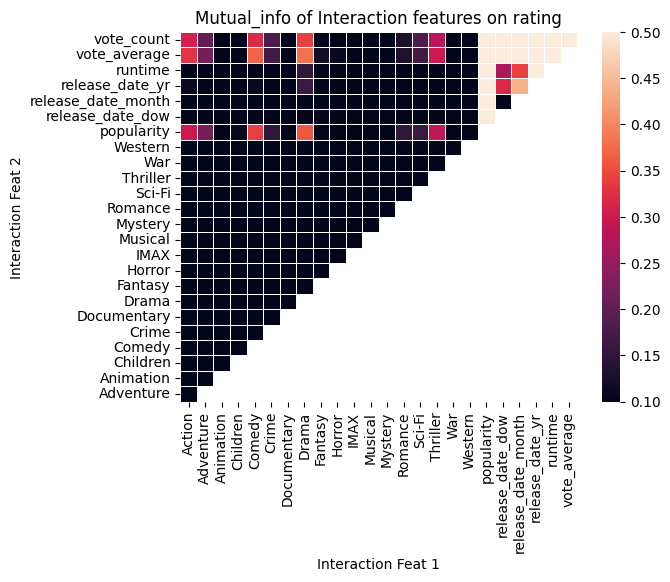

In [280]:
heat_map_feat_interaction(interaction_res[['Mutual_info']].reset_index(), 'Mutual_info')

MI numbers greater than 30% means, that they carry good information about user rating.
    
We can see here that there is good MI intereaction between Genre columns and  (popularity, vote_count, vote_average).

This concludes that interaction features carry strong informaiton on user rating.

## Old analuysis

In [316]:

def convert_timestamp_to_year(timestamp):
    date_string = ctime(timestamp)
    tokens = date_string.split(sep=" ")
    year = int(tokens[-1])
    return year

Checking Rating trend 

In [317]:
movies_ratings['rating_yr'] = movies_ratings.timestamp.apply(convert_timestamp_to_year)

<Axes: title={'center': 'How Avg rating changed by year'}, xlabel='rating_yr'>

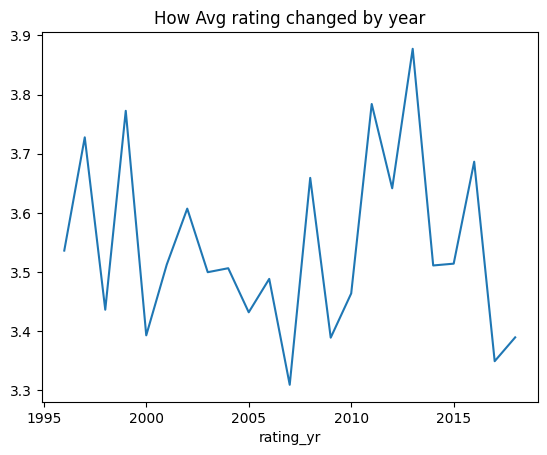

In [318]:
movies_ratings.groupby('rating_yr').rating.mean().plot(title= 'How Avg rating changed by year')

<Axes: title={'center': 'Number of movies rated by year'}, xlabel='rating_yr'>

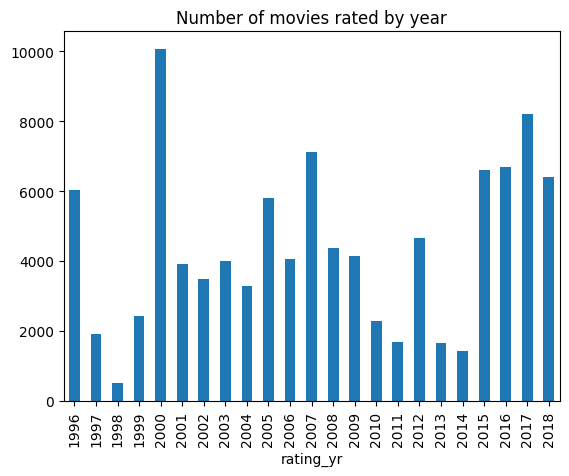

In [319]:
movies_ratings.groupby(['rating_yr']).rating.size().plot(kind='bar',title= 'Number of movies rated by year')

          rating
userId          
1       4.366379
2       3.948276
3       2.435897
4       3.555556
5       3.636364


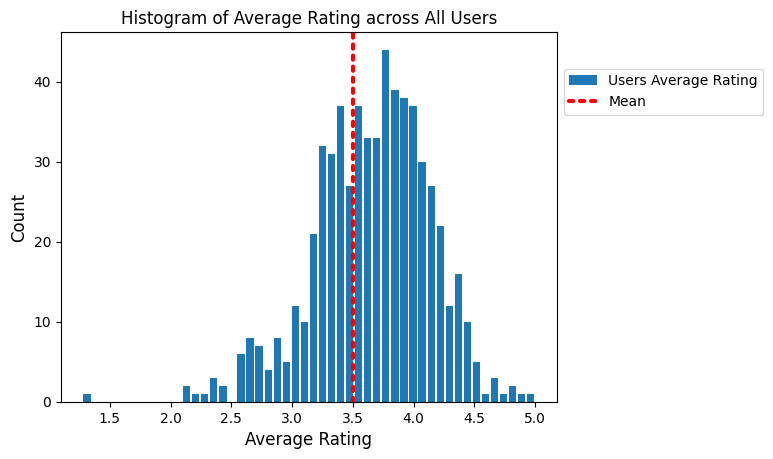

In [ ]:
# Figure 3: Visualizing the distribution of average ratings for all users
users_avg_rating = pd.DataFrame(movies_ratings.groupby('userId')['rating'].mean())
print(users_avg_rating.head())

# Plotting a histogram over the average rating for all users
users_avg_rating = users_avg_rating['rating']
fig5, ax5 = plt.subplots()
n, bins, patches = ax5.hist(users_avg_rating, label='Users Average Rating',
                            stacked=True, bins=50, rwidth=0.8)
# Set labels for histogram
ax5.set_xlabel('Average Rating', size=12)
ax5.set_ylabel('Count', size=12)
ax5.set_title('Histogram of Average Rating across All Users', size=12)

# Add a line indicating the mean rating for all users
plt.axvline(movies_ratings["rating"].mean(), color='red', linestyle='dotted', dash_capstyle="round",
            linewidth=3, label="Mean")
ax5.legend(bbox_to_anchor=(1, 0.92))

plt.show()

Text(0.5, 1.0, 'The Count of each genre in data')

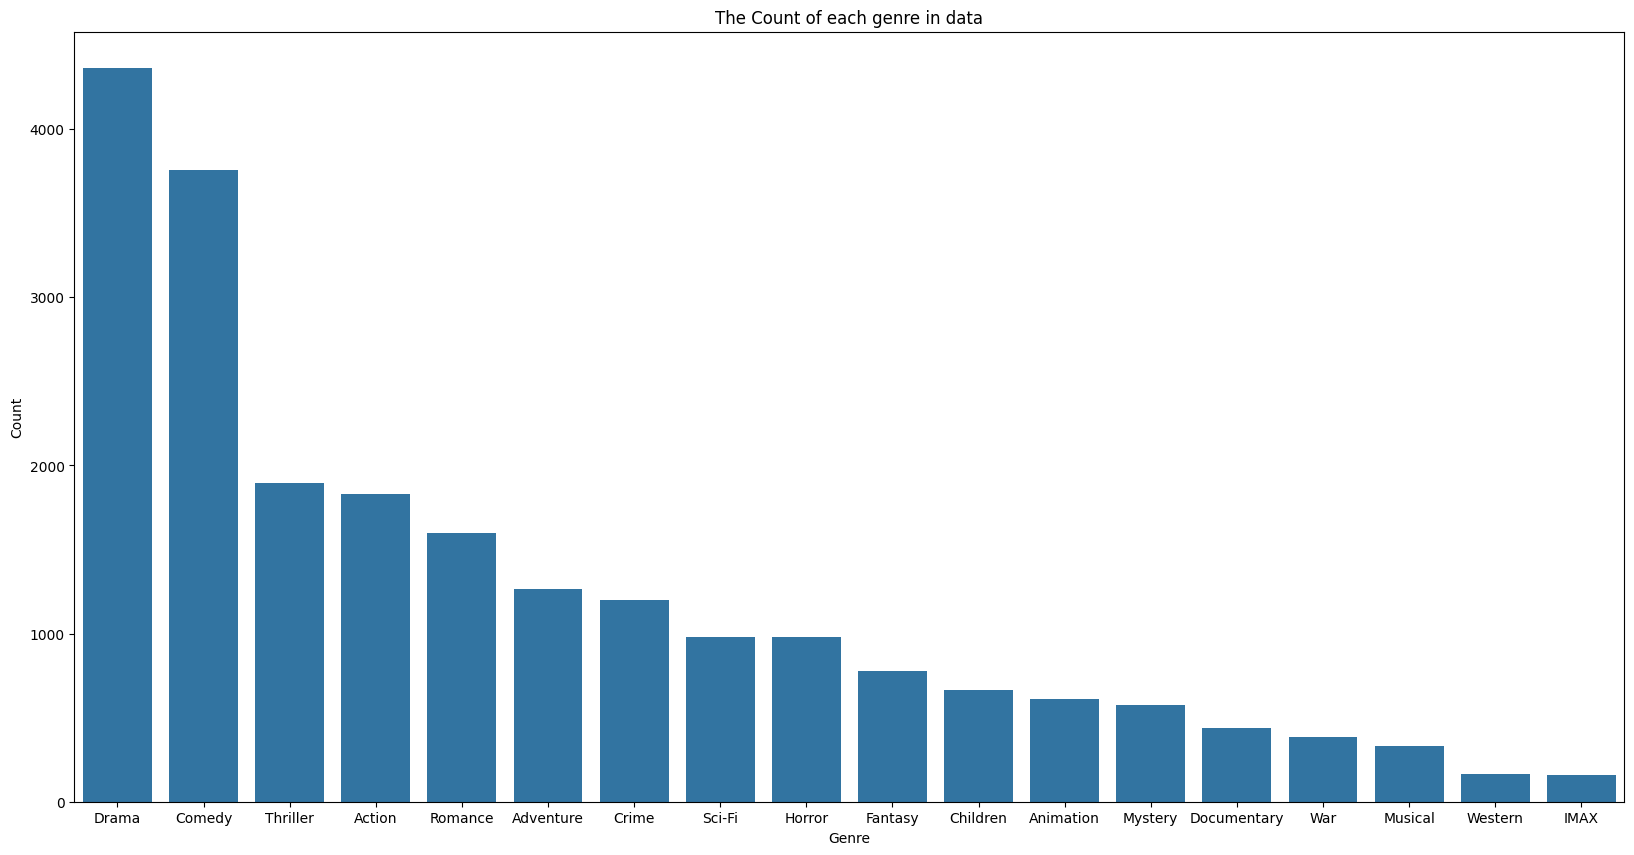

In [290]:
plt.figure(figsize=[20,10])
sns.barplot(data=movies_all[genre_cols].sum().reset_index(name='count').sort_values(by='count', ascending=False), x='index', y='count')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('The Count of each genre in data')

Continuous features

Global user understanding

In [739]:
movies_ratings['years_from_release'] = ( datetime.today()- movies_ratings['release_date']) / np.timedelta64(1, 'Y')

In [293]:
movies_ratings.head()

,movieId,title,genres,Fantasy,Children,Animation,Comedy,Adventure,Romance,Drama,Action,Thriller,Crime,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,imdbId,tmdbId,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,status,tagline,spoken_languages,cast,primary_lang,userId,rating,timestamp,rating_yr
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,114709,862.0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear on...",100.954,Toy Story,81.0,1995-10-30,7.97,17277.0,Released,Hang on for the comedy that goes to infinity and beyond!,en,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn,en,1,4.0,964982703,2000
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,114709,862.0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear on...",100.954,Toy Story,81.0,1995-10-30,7.97,17277.0,Released,Hang on for the comedy that goes to infinity and beyond!,en,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn,en,5,4.0,847434962,1996
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,114709,862.0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear on...",100.954,Toy Story,81.0,1995-10-30,7.97,17277.0,Released,Hang on for the comedy that goes to infinity and beyond!,en,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn,en,7,4.5,1106635946,2005
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,114709,862.0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear on...",100.954,Toy Story,81.0,1995-10-30,7.97,17277.0,Released,Hang on for the comedy that goes to infinity and beyond!,en,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn,en,15,2.5,1510577970,2017
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,114709,862.0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear on...",100.954,Toy Story,81.0,1995-10-30,7.97,17277.0,Released,Hang on for the comedy that goes to infinity and beyond!,en,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn,en,17,4.5,1305696483,2011


In [408]:
continuous_cols = movies_ratings.corr()['rating'].index
continuous_cols = continuous_cols.drop(['movieId', 'timestamp', 'userId', 'tmdbId', 'imdbId'])

In [409]:
movies_ratings[continuous_cols].corr()['rating'].sort_values().to_frame()

,rating
Comedy,-0.089101
release_date_yr,-0.084805
Horror,-0.065170
release_date_dow,-0.044393
Action,-0.033946
Children,-0.026941
Sci-Fi,-0.019968
rating_yr,-0.007332
Thriller,-0.004491
Fantasy,-0.003692


In [690]:
features, target = movies_ratings[continuous_cols], movies_ratings[['rating']]

In [691]:
features = features.dropna()
target = target.loc[features.index]

In [452]:
fvalue_selector = SelectPercentile(f_regression, percentile=90)
features_kbest = fvalue_selector.fit_transform(features, target)
pd.Series(fvalue_selector.pvalues_, features.columns).sort_values().map("{:.2f}".format).to_frame(name='pval')

,pval
rating,0.00
vote_count,0.00
vote_average,0.00
Drama,0.00
runtime,0.00
popularity,0.00
Comedy,0.00
release_date_yr,0.00
days_rated_from_release,0.00
Crime,0.00


In [415]:
m = mutual_info_regression(features, target)
pd.Series(m, features.columns).sort_values(ascending=False).map("{:.2f}".format).to_frame(name='M_i')

,M_i
rating,2.00
rating_yr,0.15
vote_average,0.13
popularity,0.13
vote_count,0.11
release_date_yr,0.03
runtime,0.02
days_rated_from_release,0.01
War,0.01
Drama,0.01


In [422]:
category_features = movies_ratings.select_dtypes(exclude=[float, int]).iloc[:, -4:]
category_features = category_features.fillna("Other")

In [427]:
lbl_enc = {}
for cols in category_features.columns:
    lbl_enc[cols] = TargetEncoder()
    category_features[cols] = lbl_enc[cols].fit_transform(category_features[[cols]], movies_ratings[['rating']])


In [433]:
f_selector = SelectPercentile( f_regression, percentile=90)
features_kbest = f_selector.fit_transform(category_features, movies_ratings[['rating']])

In [437]:
pd.Series(f_selector.pvalues_, category_features.columns).sort_values().map("{:.2f}".format).to_frame(name = 'm_i')

,m_i
cast_0,0.00
cast_1,0.00
cast_2,0.00
primary_lang,0.00


In [431]:
m_cat = mutual_info_regression(category_features, movies_ratings[['rating']])

In [436]:
pd.Series(m_cat, category_features.columns).sort_values(ascending=False).map("{:.2f}".format).to_frame(name = 'pval')

,pval
cast_2,0.09
cast_1,0.09
cast_0,0.08
primary_lang,0.00


In [438]:
import numpy as np

In [586]:
def heat_map_feat_interaction(ser, val_label):
    # df = ser.reset_index(name=val_label)
    ax = sns.heatmap((
        pd.concat([df['index'].str.split(' ').map(lambda x: sorted(x, reverse = True))
                .apply(pd.Series), df[val_label]],1)
                .pivot_table(index=0, columns=1, values = val_label)
                .sort_index(ascending=False)
                )
                , linewidth=.5, vmin = .25, vmax = .75)
    ax.set(xlabel='Interaction Feat 1',
        ylabel='Interaction Feat 2',
        title=f'{val_label} of Interaction features on rating')
        

In [637]:
def compare_features(X, y, verbose = True):
    
    res = []
    # mi = mutual_info_regression(X, y)
    # mi /= np.max(mi)
    # mutual_info = pd.Series(mi, X.columns).sort_values(ascending=False).map("{:.2f}".format).to_frame(name='Mutual_info')
    # res.append(mutual_info)
    
    f_test, _pv = f_regression(X, y)
    f_test /= np.max(f_test)
    pval = pd.DataFrame((f_test, _pv), index = ['f_test', 'pval'], columns= X.columns).sort_values('f_test', axis=1, ascending=False).applymap("{:.2f}".format).T
    res.append(pval)
    
    corr = pd.concat([X,y],axis=1).corr()['rating'].drop('rating')
    corr = corr.sort_values(ascending=False).map("{:.2f}".format).to_frame(name='corr')
    res.append(corr)
    if verbose:
        for r in res:
            display(r.T)
    return pd.concat(res, axis=1)

    

In [692]:
_ = compare_features(features.drop('rating',1), target)

,vote_average,vote_count,runtime,popularity,Drama,Comedy,release_date_yr,days_rated_from_release,Crime,War,Horror,release_date_dow,release_date_month,Mystery,Action,Animation,Documentary,Children,IMAX,Sci-Fi,Musical,Western,rating_yr,Adventure,Thriller,Fantasy,Romance
f_test,1.00,0.20,0.10,0.10,0.08,0.04,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
pval,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.19,0.20,0.21,0.42


,vote_average,vote_count,runtime,popularity,Drama,days_rated_from_release,Crime,War,release_date_month,Mystery,Animation,Documentary,IMAX,Musical,Western,Adventure,Romance,Fantasy,Thriller,rating_yr,Sci-Fi,Children,Action,release_date_dow,Horror,release_date_yr,Comedy
corr,0.42,0.20,0.15,0.14,0.13,0.08,0.07,0.07,0.04,0.04,0.03,0.03,0.02,0.01,0.01,0.00,0.00,-0.00,-0.00,-0.01,-0.02,-0.03,-0.03,-0.04,-0.07,-0.08,-0.09



From the above Ftest, Mutual_info and correlation tests following factors affect ratings:
* vote_average
* popularity
* vote_count
* runtime
* release_date
* Drama (Positive correlation with rating)
* Comedy (Negative correlation with rating)
* days_rated_from_release

I believe interactive features will produce more interesting information between each features.

In [513]:
poly = PolynomialFeatures(include_bias=False, interaction_only=True)
intereaction_features = pd.DataFrame(poly.fit_transform(features.drop('rating',1)), columns=poly.get_feature_names_out())
features.shape, intereaction_features.shape, 

((100507, 28), (100507, 378))


From the above Ftest, Mutual_info and correlation tests following factors affect ratings:
* vote_average
* popularity
* vote_count
* runtime
* release_date
* Drama (Positive correlation with rating)
* Comedy (Negative correlation with rating)
* days_rated_from_release

I believe interactive features will produce more interesting information between each features.

In [597]:
interaction_res = compare_features(intereaction_features, target)

,vote_average rating_yr,release_date_yr rating_yr,runtime rating_yr,release_date_dow rating_yr,release_date_month rating_yr,rating_yr,vote_average release_date_yr,runtime vote_average,vote_average,vote_average vote_count,runtime vote_count,popularity runtime,vote_count release_date_yr,popularity vote_count,popularity release_date_month,vote_average release_date_month,popularity vote_average,popularity release_date_yr,popularity,vote_average release_date_dow,popularity release_date_dow,vote_count release_date_month,vote_count rating_yr,runtime release_date_yr,vote_count release_date_dow,vote_count,popularity rating_yr,Drama rating_yr,Comedy rating_yr,release_date_yr release_date_month,Comedy vote_average,Drama popularity,Drama vote_average,runtime release_date_month,Drama vote_count,Action vote_average,Comedy popularity,Comedy vote_count,release_date_yr release_date_dow,Action rating_yr,Thriller vote_count,Action vote_count,Action popularity,Thriller rating_yr,Thriller vote_average,Thriller popularity,runtime release_date_dow,release_date_yr,Adventure popularity,vote_count days_rated_from_release,Adventure vote_average,Adventure rating_yr,Adventure vote_count,Crime vote_average,Romance rating_yr,Crime popularity,Sci-Fi rating_yr,Crime vote_count,Sci-Fi vote_average,rating_yr days_rated_from_release,Sci-Fi vote_count,release_date_yr days_rated_from_release,Drama release_date_yr,Sci-Fi popularity,runtime,Crime rating_yr,Drama runtime,popularity days_rated_from_release,Romance popularity,vote_average days_rated_from_release,Romance vote_average,Romance vote_count,Fantasy rating_yr,runtime days_rated_from_release,Horror vote_average,Children rating_yr,Fantasy vote_count,Action release_date_yr,Action runtime,Comedy runtime,Fantasy popularity,Comedy release_date_yr,Animation rating_yr,Crime runtime,Fantasy vote_average,Horror rating_yr,Children vote_count,Crime release_date_yr,Children popularity,Drama days_rated_from_release,Thriller release_date_yr,War rating_yr,War popularity,Drama release_date_month,Drama,Animation vote_count,War vote_average,Mystery vote_count,Adventure runtime,Mystery rating_yr,...,Fantasy Children,Musical release_date_dow,Fantasy Animation,Adventure,Musical runtime,IMAX release_date_yr,Fantasy Thriller,Fantasy days_rated_from_release,Musical days_rated_from_release,Fantasy Romance,Fantasy Drama,Documentary IMAX,Fantasy Action,Fantasy Crime,Fantasy Mystery,Documentary vote_average,Fantasy Musical,Fantasy Documentary,Fantasy IMAX,Musical IMAX,Western release_date_yr,IMAX Western,Musical Western,Adventure Thriller,Musical Documentary,Action Thriller,Drama Musical,Drama IMAX,Drama Western,Comedy War,Comedy Sci-Fi,Comedy Crime,Comedy Thriller,Children,Children Comedy,Action Horror,Action Mystery,Action Sci-Fi,Action IMAX,Comedy Romance,Animation days_rated_from_release,Animation release_date_dow,Drama Mystery,Comedy Musical,Romance release_date_dow,Romance release_date_month,Adventure Horror,Adventure Mystery,Adventure Sci-Fi,Adventure Musical,Adventure IMAX,Adventure Western,Adventure release_date_month,Adventure days_rated_from_release,Romance Action,Romance Mystery,Romance War,Romance IMAX,Romance Western,Comedy Western,Comedy IMAX,Thriller Horror,Thriller Sci-Fi,Thriller Musical,Mystery War,Children Western,Children IMAX,Mystery release_date_dow,Sci-Fi Documentary,Sci-Fi IMAX,Sci-Fi Western,Children Musical,Children Horror,Children Crime,War IMAX,War Western,Children Action,Children Drama,Children Romance,Children Adventure,Mystery Musical,Children release_date_month,Thriller Documentary,Horror release_date_month,Animation Western,Animation IMAX,Crime Mystery,Crime Sci-Fi,Crime War,Animation Crime,Animation Thriller,Horror War,Horror Musical,Horror IMAX,Horror Western,Animation Drama,Animation Romance,Animation Adventure,Adventure Crime,Animation Comedy
Mutual_info,1.00,0.98,0.95,0.90,0.89,0.88,0.86,0.83,0.78,0.77,0.77,0.76,0.76,0.76,0.75,0.75,0.75,0.75,0.74,0.74,0.72,0.71,0.70,0.66,0.64,0.63,0.61,0.40,0.37,0.3

,vote_average,vote_average rating_yr,vote_average release_date_yr,runtime vote_average,vote_average vote_count,vote_count,vote_count rating_yr,vote_count release_date_yr,runtime vote_count,vote_count days_rated_from_release,vote_count release_date_month,vote_count release_date_dow,popularity vote_average,popularity vote_count,Drama vote_count,popularity runtime,Drama popularity,Drama vote_average,runtime,runtime rating_yr,runtime release_date_yr,popularity,popularity rating_yr,popularity release_date_yr,Drama runtime,vote_average release_date_month,popularity days_rated_from_release,popularity release_date_month,Drama,Drama rating_yr,Drama release_date_yr,Drama release_date_month,vote_average days_rated_from_release,Crime vote_count,runtime days_rated_from_release,Drama days_rated_from_release,Crime popularity,popularity release_date_dow,Drama release_date_dow,runtime release_date_month,Comedy release_date_yr,Comedy rating_yr,Comedy,Comedy release_date_dow,Thriller vote_count,Crime vote_average,release_date_yr,days_rated_from_release,rating_yr days_rated_from_release,release_date_yr days_rated_from_release,Drama Crime,Action vote_count,Crime runtime,release_date_month days_rated_from_release,Comedy runtime,Adventure vote_count,Comedy release_date_month,War vote_average,vote_average release_date_dow,War popularity,Crime days_rated_from_release,Drama War,War vote_count,release_date_yr rating_yr,War runtime,Crime release_date_month,Crime rating_yr,Crime,Crime release_date_yr,War,War rating_yr,War release_date_yr,Horror release_date_yr,Horror,Horror rating_yr,Horror release_date_month,War release_date_month,Horror release_date_dow,Sci-Fi vote_count,Mystery vote_count,War release_date_dow,Horror runtime,Crime release_date_dow,War days_rated_from_release,Thriller Horror,release_date_dow days_rated_from_release,Adventure popularity,Comedy vote_count,Comedy vote_average,Romance vote_count,Animation vote_count,Comedy Action,Thriller Crime,Mystery vote_average,Horror vote_average,Fantasy vote_count,release_date_yr release_date_dow,Action release_date_dow,release_date_dow rating_yr,release_date_dow,...,Comedy Adventure,Romance release_date_month,Drama Musical,rating_yr,Romance Mystery,War Documentary,Animation Action,Romance runtime,Comedy Mystery,Romance IMAX,IMAX Western,Crime Western,Comedy Musical,Fantasy release_date_month,Sci-Fi Musical,Mystery War,Horror IMAX,Adventure Crime,Fantasy runtime,Romance Musical,release_date_month release_date_dow,Comedy IMAX,Sci-Fi days_rated_from_release,Adventure release_date_dow,Comedy Documentary,Action Musical,Thriller IMAX,Children Mystery,Romance Horror,Musical Western,Animation Crime,War Musical,Children Thriller,Thriller Musical,Sci-Fi vote_average,Comedy Thriller,Children Drama,Children Romance,Comedy Crime,Sci-Fi War,Thriller release_date_yr,Adventure rating_yr,Documentary IMAX,Adventure Documentary,Adventure,Adventure Romance,Fantasy release_date_yr,Thriller,Thriller rating_yr,Animation Mystery,Fantasy,Fantasy rating_yr,Adventure release_date_yr,Horror War,Sci-Fi IMAX,Drama Documentary,Animation War,Animation Western,Romance Sci-Fi,Adventure Western,Thriller Documentary,Documentary Western,Animation Horror,Thriller release_date_dow,Thriller Sci-Fi,Romance,Animation Thriller,Animation Documentary,Horror Musical,Romance rating_yr,Fantasy Children,Crime Sci-Fi,Action Crime,Horror Western,Romance Crime,Romance release_date_yr,Fantasy War,Crime Documentary,Action Documentary,Musical release_date_dow,Romance Western,Musical Documentary,Mystery Documentary,War IMAX,Thriller Western,Action vote_average,Romance release_date_dow,Children Adventure,Adventure Horror,Crime Musical,Romance Documentary,Children Documentary,Fantasy Mystery,Mystery Musical,Fantasy Western,Adventure Sci-Fi,Adventure Mystery,War Western,Fantasy Documentary,Sci-Fi Documentary
f_test,1.00,0.99,0.99,0.39,0.23,0.20,0.20,0.20,0.19,0.17,0.17,0.16,0.16,0.13,0.13,0.12,0.12,0.11,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.09,0.09,0.08,0.08,0

,vote_average,vote_average rating_yr,vote_average release_date_yr,runtime vote_average,vote_count days_rated_from_release,vote_average vote_count,vote_count,vote_count rating_yr,vote_count release_date_yr,runtime vote_count,popularity vote_average,vote_count release_date_month,vote_count release_date_dow,popularity days_rated_from_release,popularity runtime,Drama vote_count,popularity vote_count,Drama popularity,vote_average days_rated_from_release,popularity,popularity rating_yr,popularity release_date_yr,runtime rating_yr,runtime,runtime days_rated_from_release,runtime release_date_yr,popularity release_date_month,Drama vote_average,vote_average release_date_month,Drama runtime,Crime vote_count,Drama days_rated_from_release,release_date_yr days_rated_from_release,days_rated_from_release,rating_yr days_rated_from_release,Crime popularity,popularity release_date_dow,Drama release_date_month,release_date_month days_rated_from_release,Drama,Drama rating_yr,Drama release_date_yr,runtime release_date_month,Thriller vote_count,Crime days_rated_from_release,Crime vote_average,War vote_count,War popularity,Drama release_date_dow,Drama Crime,Crime runtime,War vote_average,release_date_dow days_rated_from_release,War runtime,Drama War,Adventure vote_count,War,War rating_yr,War days_rated_from_release,War release_date_month,War release_date_yr,Crime release_date_month,Action vote_count,Crime rating_yr,Crime,Crime release_date_yr,Comedy vote_count,Romance vote_count,War release_date_dow,Adventure popularity,vote_average release_date_dow,Mystery vote_count,Crime release_date_dow,Sci-Fi vote_count,Thriller Crime,Mystery days_rated_from_release,Adventure days_rated_from_release,Comedy War,Fantasy vote_count,Romance days_rated_from_release,Romance War,Thriller popularity,Thriller days_rated_from_release,release_date_month rating_yr,release_date_month,release_date_yr release_date_month,Mystery vote_average,Mystery popularity,Fantasy popularity,Horror vote_count,Animation vote_count,Drama Western,Mystery release_date_month,Adventure vote_average,Crime Horror,Animation popularity,Action popularity,Romance Drama,Musical vote_count,Comedy Drama,...,Crime Documentary,Comedy Adventure,Fantasy Crime,Animation Thriller,Fantasy release_date_dow,Comedy Romance,Children days_rated_from_release,Horror IMAX,Adventure Action,Crime Sci-Fi,Action Mystery,Horror Musical,Sci-Fi Musical,Action vote_average,Adventure release_date_dow,Action Documentary,Children Drama,Romance Thriller,Romance Action,Horror Documentary,Children Thriller,Children Horror,Action Horror,Animation War,Romance Horror,Children War,Crime War,Musical Western,Horror days_rated_from_release,Documentary vote_count,Comedy Documentary,Action IMAX,Fantasy Horror,Thriller War,Children vote_average,Fantasy Action,Drama Horror,Sci-Fi runtime,Thriller IMAX,Adventure Crime,Sci-Fi IMAX,Horror popularity,Romance Sci-Fi,Children release_date_month,Action runtime,Comedy Mystery,Action Sci-Fi,Animation Western,Adventure Thriller,Horror Mystery,Children Comedy,Action Crime,Fantasy Thriller,Sci-Fi rating_yr,Sci-Fi,Sci-Fi Western,Sci-Fi release_date_yr,Children Sci-Fi,Children rating_yr,Children,Children release_date_yr,Children Western,Children runtime,Action release_date_month,Horror Sci-Fi,Fantasy Sci-Fi,Children Action,Sci-Fi release_date_month,Action Thriller,Comedy Horror,Comedy Western,Horror vote_average,Sci-Fi release_date_dow,Comedy Sci-Fi,Children release_date_dow,Horror runtime,Action rating_yr,Action,Action release_date_yr,Comedy vote_average,Horror release_date_dow,Thriller Horror,Horror rating_yr,Horror,Horror release_date_yr,release_date_dow rating_yr,release_date_dow,Action release_date_dow,Comedy Action,release_date_yr release_date_dow,Horror release_date_month,Comedy release_date_month,Comedy runtime,Comedy rating_yr,Comedy,Comedy release_date_yr,Comedy release_date_dow,release_date_yr rating_yr,release_date_yr,Sci-Fi Documentary
corr,0.27,0.27,0.26,0.19,0.17,0.16,0.15,0.14,0.14,0.14,0.13,

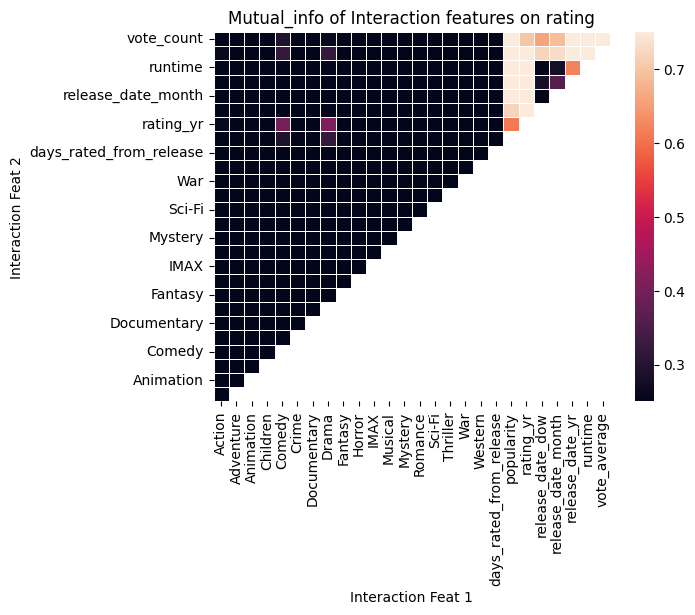

In [598]:
heat_map_feat_interaction(interaction_res[['Mutual_info']].reset_index(), 'Mutual_info')


From the above Ftest, Mutual_info and correlation tests following factors affect ratings:
* vote_average x rating_yr/release_date_yr
* release_date x rating_yr:  weak -ve correlation
* populatiry x vote_count/vote_avg, runtime, release_date_yr
* runtime
* release_date_yr (Negative correlation with rating, Meaning users are criticcal of NEW movies)
* Drama (Positive correlation with rating)
* Comedy and rating/release date (Negative correlation with rating, Meaning users are more critical of new comedy movies)
* days_rated_from_release

I believe interactive features will produce more interesting information between each features.

Compare features for each user

In [721]:
features.columns

Index(['Fantasy', 'Children', 'Animation', 'Comedy', 'Adventure', 'Romance',
       'Drama', 'Action', 'Thriller', 'Crime', 'Horror', 'Mystery', 'Sci-Fi',
       'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'popularity',
       'runtime', 'vote_average', 'vote_count', 'release_date_yr',
       'release_date_month', 'release_date_dow', 'rating', 'rating_yr',
       'days_rated_from_release'],
      dtype='object')

In [710]:
def user_compare_features(user_df_features, user_df_target, cmp_item = 'pval'):
    if user_df_features.shape[0] < 20:
        return pd.Series([])

    res_df = compare_features(user_df_features, user_df_target, verbose = False).astype(float)
    if cmp_item == 'pval':
        ser = pd.Series(
            np.select([res_df[cmp_item] < 0.05, res_df[cmp_item] >= 0.05], ['Significant', 'Not Significant']) 
        , index = res_df.index)
    if cmp_item == 'corr':
        ser =  pd.Series(
            np.select([res_df[cmp_item] > 0.33, res_df[cmp_item] < -0.33, ],[ 'corr > 0.33', 'corr < -0.33'],default='neutral')
        , index = res_df.index)
    return ser

In [712]:
corr_user_compare_res = []
for u in tqdm(movies_ratings.userId.unique()):
    # print(u,movies_ratings[movies_ratings.userId == u])
    x = movies_ratings[movies_ratings.userId == u]
    feat = x[continuous_cols].dropna().drop('rating',1)
    target = x.loc[feat.index, ['rating']]
    r = user_compare_features(feat, target, cmp_item = 'corr')
    r.name = u
    corr_user_compare_res.append(r)


  0%|          | 0/610 [00:00<?, ?it/s]

100%|██████████| 610/610 [00:09<00:00, 65.74it/s]


In [717]:
#  User level feature importance wrt rating. 
# We can see that  58% of the users find vote_average +ve correlated with rating
(pd.DataFrame(corr_user_compare_res)
 .apply(pd.Series.value_counts, normalize=True).T.mul(100)
 .applymap("{:.1f}%".format).sort_values('neutral')
)

,corr < -0.33,corr > 0.33,neutral
vote_average,0.8%,57.5%,41.6%
vote_count,0.7%,21.8%,77.5%
runtime,1.5%,12.6%,85.9%
popularity,0.8%,12.6%,86.6%
days_rated_from_release,3.9%,7.4%,88.7%
Drama,1.6%,9.2%,89.2%
release_date_yr,6.7%,3.6%,89.7%
Comedy,6.7%,1.6%,91.6%
Action,5.9%,1.6%,92.5%
Thriller,3.3%,3.4%,93.3%


In [ ]:
pval_user_compare_res = []
for u in tqdm(movies_ratings.userId.unique()):
    # print(u,movies_ratings[movies_ratings.userId == u])
    x = movies_ratings[movies_ratings.userId == u]
    feat = x[continuous_cols].dropna().drop('rating',1)
    target = x.loc[feat.index, ['rating']]
    r = user_compare_features(feat, target, cmp_item = 'pval')
    r.name = u
    pval_user_compare_res.append(r)


In [718]:
#  User level feature importance wrt rating using F-test 
#  We can see that 71% of the users find  vote_average as significant

(pd.DataFrame(pval_user_compare_res)
 .apply(pd.Series.value_counts, normalize=True).T.mul(100)
 .applymap("{:.1f}%".format).sort_values('Not Significant')
)


,Not Significant,Significant
vote_average,28.5%,71.5%
vote_count,52.6%,47.4%
popularity,63.4%,36.6%
runtime,65.2%,34.8%
days_rated_from_release,69.2%,30.8%
release_date_yr,69.8%,30.2%
Drama,70.2%,29.8%
Action,75.9%,24.1%
Comedy,76.9%,23.1%
Adventure,82.5%,17.5%


In [720]:
movies_ratings.to_csv(DIR_DATA.joinpath('movies_ratings.csv'), index=False)

In [722]:
movies_all.to_csv(DIR_DATA.joinpath('movies_all.csv'), index=False)